# ExperimentAllTriplet
### Take the dataset where the negatives are comprised of enhancers and random genomic data from the four controls (length-repeats, length-no_repeats, length-gc-repeats, length-gc-no_repeats).
### Train a single separable convolutional classifier on triplets and evaluate

## Imports

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# # Credit: https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
import data
import numpy as np
import nets
from tensorflow import keras
from loaders import PremadeTripletClassifierSequence
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from Bio import motifs
from Bio.Seq import Seq
from scipy.signal import find_peaks

## Files

In [8]:
data_dir = '../Data/Datasets/All'


train_sequence = f'{data_dir}/train_sequences.fa'
valid_sequence = f'{data_dir}/valid_sequences.fa'
test_sequence = f'{data_dir}/test_sequences.fa'

reverse_train_sequence = f'{data_dir}/reverse_train_sequences.fa'
reverse_valid_sequence = f'{data_dir}/reverse_valid_sequences.fa'
reverse_test_sequence = f'{data_dir}/reverse_test_sequences.fa'

train_triplet_dis = f'{data_dir}/train_triplet_dis.npy'
valid_triplet_dis = f'{data_dir}/valid_triplet_dis.npy'
test_triplet_dis = f'{data_dir}/test_triplet_dis.npy'

train_triplet_sim = f'{data_dir}/train_triplet_sim.npy'
valid_triplet_sim = f'{data_dir}/valid_triplet_sim.npy'
test_triplet_sim = f'{data_dir}/test_triplet_sim.npy'

## Parameters

In [9]:
codings_size=100
exp_filter_num=4
exp_filter_1d_size= 11

allow_reverse = True
max_len = 600

learning_rate = 0.1
momentum = 0.9
is_nesterov = True
patience = 20
monitor = 'val_crm_f1_score'
start_from_epoch = 10

## Loading Data

In [10]:
train = data.FantomToOneHotConverter(train_sequence, 0, max_len).seq_matrix
reverse_train = data.FantomToOneHotConverter(reverse_train_sequence, 0, max_len).seq_matrix if allow_reverse else None

In [11]:
valid = data.FantomToOneHotConverter(valid_sequence, 0, max_len).seq_matrix
reverse_valid = data.FantomToOneHotConverter(reverse_valid_sequence, 0, max_len).seq_matrix if allow_reverse else None

In [12]:
test = data.FantomToOneHotConverter(test_sequence, 0, max_len).seq_matrix
reverse_test = data.FantomToOneHotConverter(reverse_test_sequence, 0, max_len).seq_matrix if allow_reverse else None

In [13]:
train_seq = PremadeTripletClassifierSequence(train, train_triplet_sim, train_triplet_dis, batch_size = 1024, reverse_x_in =reverse_train)
valid_seq = PremadeTripletClassifierSequence(valid, valid_triplet_sim, valid_triplet_dis, batch_size = 1024, reverse_x_in =reverse_valid)
test_seq = PremadeTripletClassifierSequence(test, test_triplet_sim, test_triplet_dis, batch_size = 1024, reverse_x_in =reverse_test)

In [14]:
for x_batch, y_batch in train_seq:
    _, d1, d2, d3 = x_batch.shape

## Creating Model

In [15]:
model = nets.make_conv_classifier_no_batch(codings_size, (d1, d2, d3), exp_filter_1d_size, filter_num=exp_filter_num)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 600, 3)]       0         
                                                                 
 masking (Masking)           (None, 4, 600, 3)         0         
                                                                 
 separable_conv2d (Separable  (None, 1, 598, 4)        48        
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 1, 598, 4)        16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 598, 4)         0         
                                                                 
 reshape (Reshape)           (None, 598, 4)            0     

In [12]:
opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=is_nesterov) # 0.1
model.compile(loss='mse', metrics=['accuracy', nets.crm_specificity, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), nets.crm_f1_score], optimizer=opt) #  

In [13]:
early_stopping = keras.callbacks.EarlyStopping(patience=patience, min_delta=1/100000, restore_best_weights=True, monitor=monitor,mode='max') #start_from_epoch = start_from_epoch #val_precision

In [14]:
def exponential_decay_fn(epoch, lr):
    '''
    This function decreases the learning rate according to the epoch
    '''
    return lr*0.1**(1/100)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Training Model

In [15]:
model.fit(train_seq, epochs=500, validation_data=valid_seq, workers=26, callbacks=[early_stopping, lr_scheduler])

Epoch 1/500
72/72 [==============================] - 38s 491ms/step - loss: 0.2355 - accuracy: 0.6031 - crm_specificity: 0.5928 - recall: 0.6138 - precision: 0.6012 - crm_f1_score: 0.6065 - val_loss: 0.2524 - val_accuracy: 0.4989 - val_crm_specificity: 0.0000e+00 - val_recall: 1.0000 - val_precision: 0.4989 - val_crm_f1_score: 0.6655 - lr: 0.0977
Epoch 2/500
72/72 [==============================] - 35s 483ms/step - loss: 0.2198 - accuracy: 0.6398 - crm_specificity: 0.6180 - recall: 0.6616 - precision: 0.6340 - crm_f1_score: 0.6471 - val_loss: 0.2766 - val_accuracy: 0.5058 - val_crm_specificity: 0.0156 - val_recall: 0.9983 - val_precision: 0.5023 - val_crm_f1_score: 0.6682 - lr: 0.0955
Epoch 3/500
72/72 [==============================] - 37s 508ms/step - loss: 0.2168 - accuracy: 0.6467 - crm_specificity: 0.6393 - recall: 0.6543 - precision: 0.6446 - crm_f1_score: 0.6492 - val_loss: 0.2750 - val_accuracy: 0.5165 - val_crm_specificity: 0.0389 - val_recall: 0.9943 - val_precision: 0.5084 -

In [16]:
# model.save("CAM_Model3")

## Evaluating Model

In [17]:
# model = keras.models.load_model("ExperimentAllTripletModel", custom_objects = {"crm_specificity": nets.crm_specificity, "crm_f1_score": nets.crm_f1_score})

In [18]:
# nets.print_results(train_seq, model)

In [19]:
# nets.print_results(valid_seq, model)

In [20]:
# nets.print_results(test_seq, model)

In [46]:
# Reload model
model = keras.models.load_model("CAM_Model3", custom_objects = {"crm_specificity": nets.crm_specificity, "crm_f1_score": nets.crm_f1_score})

In [47]:
# Credit: "Deep Learning with Python by Francois Chollet, Chapter 9, Page 273"

last_conv_layer_name = "activation_4"
classifier_layer_names = [
    "global_max_pooling1d",
    "dense",
    "batch_normalization_5",
    "activation_5",
    "dense_1"
]

last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [48]:
last_conv_layer.output.shape

TensorShape([None, 48, 64])

In [49]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [50]:
for x_batch, y_batch in train_seq:
    _, d1, d2, d3 = x_batch.shape
    print(x_batch.shape)
    break

(1024, 4, 600, 3)


### Experiment with different triplets

In [51]:
index = 80

In [52]:
sequence = np.expand_dims(x_batch[index], axis = 0)

In [53]:
y_batch[index]

array([0.])

In [54]:
print(sequence.shape)

(1, 4, 600, 3)


In [55]:
# Send sequence to model and watch last convolutional layer output

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(sequence)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    print(" Prediction:", preds[0].numpy())
    # top_pred_index = tf.argmax(preds[0])
    # top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(preds, last_conv_layer_output)

 Prediction: [0.5499542]


In [56]:
print(grads.shape)

(1, 48, 64)


In [57]:
# Can only be run once; otherwise will ruin the correct predictions

pooled_grads = tf.reduce_mean(grads, axis=(0, 1)).numpy()


In [58]:
print(pooled_grads.min(), pooled_grads.max())

-0.0030552943 0.0029673476


In [59]:
scaled_grads = (pooled_grads - pooled_grads.min()) / (pooled_grads.max() - pooled_grads.min())

In [60]:
print(scaled_grads.min(), scaled_grads.max())

0.0 1.0


In [61]:
last_conv_layer_output = last_conv_layer_output[0].numpy()

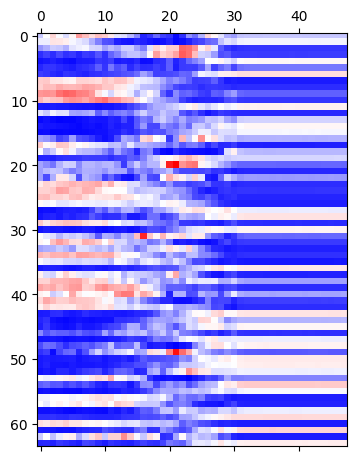

In [62]:
plt.matshow(last_conv_layer_output.transpose(),cmap='bwr')

In [63]:
#print(last_conv_layer_output[0, :])
for i in range(scaled_grads.shape[-1]):
    last_conv_layer_output[:, i] *= scaled_grads[i]

In [64]:
print(last_conv_layer_output[0, :])

[ 0.3207533   0.29934052 -0.01355963 -0.9428547  -0.6508931  -0.30067834
 -0.09352464  1.1646346   0.13635185  1.1750153   1.8610156  -0.62892085
  0.41366655 -0.6085255  -0.541161   -0.5938039   0.07126719  1.063654
  0.607944   -0.7112045   0.0063661   0.01717274  0.03710341  0.13302213
  0.75854313  1.6889402   0.98605275 -0.568675   -1.219877    1.5225406
 -0.99240285  0.35101366  0.52019626  0.06931683  0.81184447  0.77295256
 -0.4842029   0.8370564   1.0826279   1.5805107   0.7841954   0.32499412
  0.78608257 -0.8879162  -1.0293447  -0.79736763 -0.14464332 -0.93534005
 -0.3192334  -1.0681299  -0.9240571  -0.5185537  -0.          0.28606448
 -0.27885035 -0.37150538  0.62474555  0.86037886 -0.60321885 -0.09111662
  0.9134627  -0.6877876   0.29844734 -0.89484245]


In [65]:
heatmap = np.mean(last_conv_layer_output, axis=-1)
print(heatmap.shape)

(48,)


In [66]:
# This code is based on code generated by Bard
def interpolate_array(array, new_size):
    return np.interp(np.linspace(0, 1, new_size), np.linspace(0, 1, len(array)), array)   

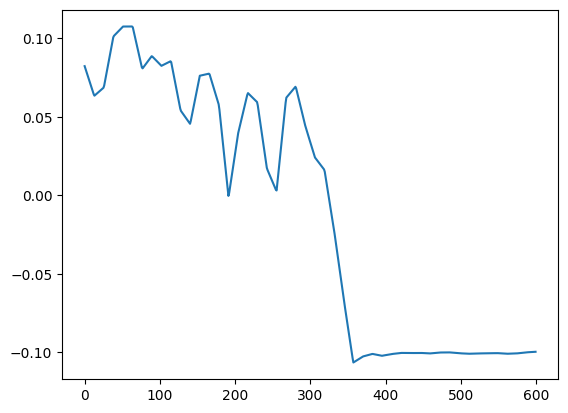

In [67]:
heatmap_interpolated = interpolate_array(heatmap, 600)
plt.plot(heatmap_interpolated)

### Not used from this point forward

In [68]:
print(sequence[0, :, :, 0])
index_to_nucleotide = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
decoded_sequences = []
for channel in range(sequence.shape[-1]):
    seq = []
    for pos in range(sequence.shape[2]):
        for one_hot in range(sequence.shape[1]):
            if sequence[0, one_hot, pos, channel] == 1:
                seq.append(index_to_nucleotide[one_hot])

    decoded_sequence = ''.join(seq)
    decoded_sequences.append(f'>seq{channel}\n{decoded_sequence}')

for seq in decoded_sequences:
    print(seq)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
>seq0
CTGAAGCAGGGTTGCCAAGCTCTGCCAAAGACCATTTGCTCAGAGGCACATTTGAGATGCTGTGACAACTTTCAGGGGCACCACTGAAATTCTTGATGACTTGTCAGTCTCTTCTCTATTTCCGCCCAGAACACCACGGGCTGCCTAAACACCCAAGTCCCACAAAATATAGGACTGGTCTAATGTGTCCCTGGAAACTATTGAGACAAACCCATTATCTGAGAAGCCAGGACGAGTTATAATTAGAAGCCTGATGAGTCAGAGCTCATGGGCACTAGCTCAGAAGCCCTCACTCATAAGATGACACATCAGCTTGACGTCCGCTGGAGCTCATCCTGGGCGTCAGAATTCAGCCTCGTACAAGGATGGAAGGAATCGGCTGGAGAGGTGGGAGAGTCGCTGAGCACAAGGACAGGCCTGCTGGGCCCAGCCTCTCGCCAGGAACACAGAGCATCTCACACAGGAAGCCCAGGC
>seq1
TCAAAAAAAAAAAAAAAAATTAAAAGACATGATCCCTTATGCAAATTCTGCCACAAAGAAAAAGTTCCCCAAAAAGGTTTTTAAAAATCCTGTAAAACCCCACCACCCAGCAACAGCATTACTGAAAATTCAAACACCCTCTTTGTCAACATGCTGTGTATGTATTATATTTTTTATTCCAGACACATGCTCTTTAATAGGAAGAATGCTGGGGGAACTTGGGCAGGCAAGGAGCCAGGCAGGGTG
>seq2
GCCCTCTCCTGGTGCCCGGCCGGTGGTGTCTACACGGAGTCCACCTCCTCTACCCTCCCGTCTCTGCACTTTCCTGAAAGTGCTTTCCCCACAGCTGCCCCTCTGTTGCTAAGCCCAGTGGCCTCTCACCGCTGACCTTCTCAGGCCCCTGGCTTCCCT

## Grab peak coordinates of graph and store them into a separate file 

0.0752682705765873
Peaks found at: [ 63  89 114 165]
[(63, 0.10752610082369615), (89, 0.08858820065880857), (114, 0.0853593288135648), (165, 0.07746837711045658)]


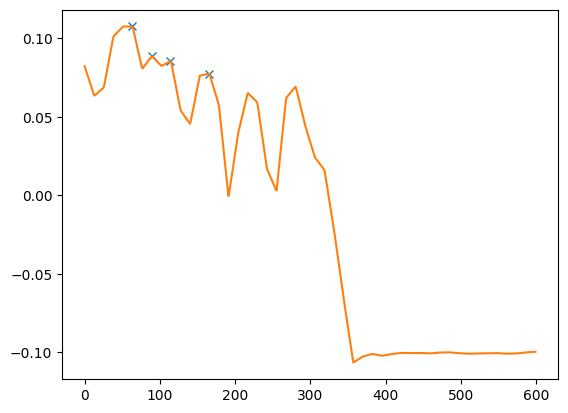

In [69]:
dynamic_height = 0.7 * np.max(heatmap_interpolated)
print(dynamic_height)
peaks, _ = find_peaks(heatmap_interpolated, height=dynamic_height)
print(f"Peaks found at: {peaks}")
coordinates = [(x, heatmap_interpolated[x]) for x in peaks]
print(coordinates)
plt.plot(peaks, heatmap_interpolated[peaks], "x")
plt.plot(heatmap_interpolated)
plt.show()

In [70]:
# Write as a seperate file 
with open(f'../Coordinates/FP_1_coordinates_{index}.txt', 'w') as f:
    for x, y in coordinates:
        f.write(f"{x}, {y}\n")